Rzut ukośny kuli z oporem powietrza i gęstością powietrza zmienną z wysokością - optymalizacja kąta rzutu przy różnych objętości kuli i funkcji gęstości dla maksymalizacji zasięgu, wizualizacja i serializacja wyników

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import msgpack

Klasa do zapisu danych i serializacja
msgpack.dump(clist, open( 'bbb.dat', "wb" ), default=enc_full)
recovered_list = msgpack.load(open( 'bbb.dat', "rb" ), ext_hook=dnc)

In [2]:
class Case:
    def __init__(self, id):
        self.id = id # File name from which we will read
        
        self.time = 0 # solution time
    
        self.X = np.array # X coordinate
        self.Y = np.array # Y coordinate

In [3]:
"""Encoding function"""
def enc_full(obj):
    if type(obj) == Case: # make sure obj is of some type
        code = 1 # A flag determining the type
        # pack and return
        return msgpack.ExtType(code, msgpack.packb([obj.id, obj.time,
                                             obj.X.tobytes(),
                                             obj.Y.tobytes()]))
    raise TypeError # Rise an error if type not handled

In [4]:
"""Decoding function"""
def dnc(code, data):
    if code == 1: # a flag determining the type
        # call the unpack on the data passed in here
        id, time, X, Y = msgpack.unpackb(data)
        
        # make the object
        c = Case(id)
        
        # feed it with data
        c.time = time
        # Note that numpy arrays need to be handled in a speciall way
        c.X = np.frombuffer(X)
        c.Y = np.frombuffer(Y)
        # return the object outside
        return c
    # in case the type is either a build in or other
    return msgpack.ExtType(code, data)

In [25]:
#Dane
m = 0.15 #baseball
D = 0.075
R = D / 2
g = 9.81
C_d = 0.5
S = math.pi * R ** 2

#Gęstość
def density(h):
  ro = -0.2 / 1500 * h + 1.2
  return ro

def round10(num):
    return math.ceil(num / 100) * 10

In [26]:
#Inicjalizacja
dt = 1e-3
tp = 0
tk = 5
x = 0
y = 0
v0 = 15
alfa0 = math.radians(60)
vx0 = v0 * math.cos(alfa0)
vy0 = v0 * math.sin(alfa0)
#Przechowanie danych
t_tablica = []
x_tablica = []
y_tablica = []
t = tp
v = v0
vx = vx0
vy = vy0
while t <= tk:
    t_tablica.append(t)
    x_tablica.append(x)
    y_tablica.append(y)

    D = 1/2 * C_d * S * density(y)

    ax = -(D / m) * v * vx
    ay = -g -(D/m) * v * vy
    
    vx = vx + ax * dt
    vy = vy + ay * dt

    v = math.sqrt(vx ** 2 + vy ** 2)

    x = x + vx * dt + 1/2 * ax * dt ** 2
    y = y + vy * dt + 1/2 * ay * dt ** 2

    t = t + dt

    if (len(t_tablica) > 20 and y<0):
        t_tablica.append(t)
        x_tablica.append(x)
        y_tablica.append(y)
        break



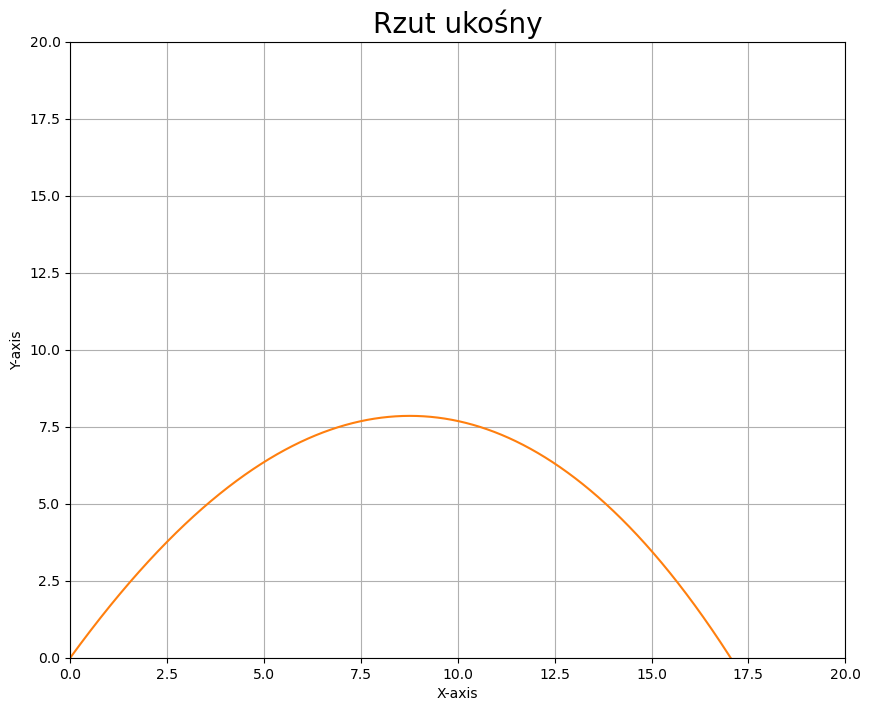

In [27]:
figure, ax = plt.subplots(figsize=(10, 8))
line, = ax.plot(x, y)
 
# setting title
plt.title("Rzut ukośny", fontsize=20)
 
# setting x-axis label and y-axis label
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.grid()

plt.axis([0, round10(max(x_tablica)) + 10, 0, round10(max(y_tablica)) + 10])

plt.plot(x_tablica,y_tablica)


FUNKCJA WYZNACZAJĄCA ZASIĘG RZUTU

In [29]:
def zasieg(kat,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,id):
    #Inicjalizacja
    x = x0
    y = y0
    alfa0 = math.radians(kat)
    vx0 = v0 * math.cos(alfa0)
    vy0 = v0 * math.sin(alfa0)
    #Przechowanie danych
    t_table = []
    x_table = []
    y_table = []
    vx_table = []
    vy_table = []
    t = tp
    v = v0
    vx = vx0
    vy = vy0
    while t <= tk:
        t_table.append(t)
        x_table.append(x)
        y_table.append(y)
        vx_table.append(vx)
        vy_table.append(vy)
        D = 1/2 * C_d * S * density(y)

        ax = -(D / m) * v * vx
        ay = -g -(D/m) * v * vy
        
        vx = vx + ax * dt
        vy = vy + ay * dt

        v = math.sqrt(vx ** 2 + vy ** 2)

        x = x + vx * dt + 1/2 * ax * dt ** 2
        y = y + vy * dt + 1/2 * ay * dt ** 2

        t = t + dt

        if (len(t_table) > 20 and y<0):
            t_table.append(t)
            x_table.append(x)
            y_table.append(y)
            xe = x_table[-2]
            ye = y_table[-2]
            te = t_table[-2]
            vxe = vx_table[-2]
            vye = vy_table[-2]
            break
    dat = Case(id)
    dat.time = tk
    dat.X = np.array(x_table)
    dat.Y = np.array(y_table)
    i = 0
    t = te
    x = xe
    y = ye
    vx = vxe
    vy = vye
    v = math.sqrt(vx ** 2 + vy ** 2)
    while abs(y)>=eps and i<N:
        D = 1/2 * C_d * S * density(y)

        ax = -(D / m) * v * vx
        ay = -g -(D/m) * v * vy
        
        vx = vx + ax * dt2
        vy = vy + ay * dt2

        v = math.sqrt(vx ** 2 + vy ** 2)

        x = x + vx * dt2 + 1/2 * ax * dt2 ** 2
        y = y + vy * dt2 + 1/2 * ay * dt2 ** 2
     
        t = t + dt2
        i = i + 1

    xstar = x
    ystar = y

    if draw == 1:
        figure, ax = plt.subplots(figsize=(10, 8))
        line, = ax.plot(x, y)
        
        # setting title
        plt.title("Rzut ukośny", fontsize=20)
        
        # setting x-axis label and y-axis label
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")

        plt.grid()

        plt.axis([0, max(x_table) + 10, 0, max(y_table) + 10])

        plt.plot(x_table,y_table)

    #return xstar,ystar
    return -xstar,ystar,dat


9.389092030945454 6.725427065009403e-05


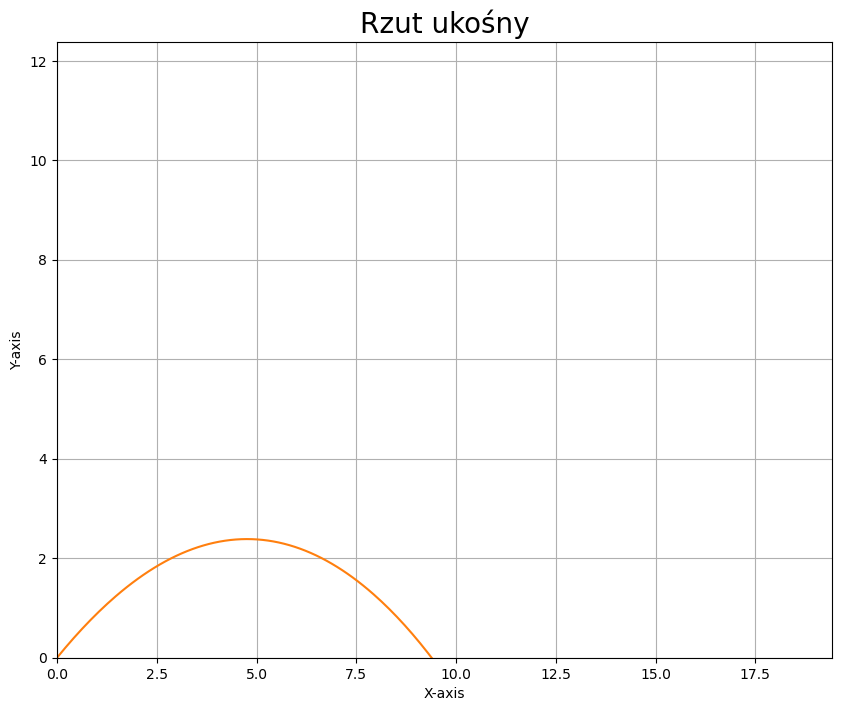

In [31]:
xstar,ystar,dump =zasieg(45,0.01,0,10,0,0,10,1e-4,1e-4,1e3,1,1)
print(-xstar,ystar)

OPTYMALIZACJA KĄTA

In [35]:
#Dane
m = 0.15 #baseball
D = 0.075
#D = 0.75
R = D / 2
g = 9.81
C_d = 5.0
S = math.pi * R ** 2
v0 = 50
dt = 0.01
x0 = 0
y0 = 0
tp = 0
tk = 10
dt2 = 1e-6
eps = 1e-6
N = 1e4
draw = 0
#Gęstość
def density(h):
  #ro = -0.2 / 1500 * h + 1.2
  ro = math.exp(-h*0.5) + 0.2
  return ro

63.00411378875911 43.5


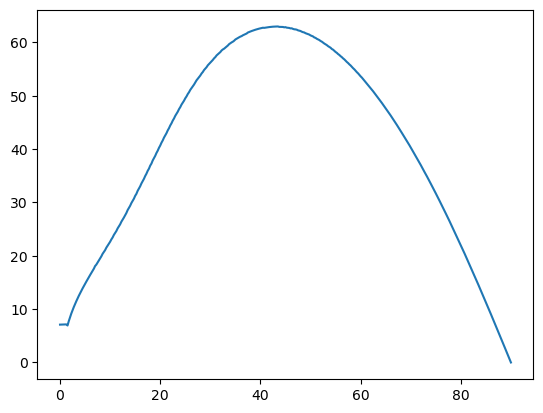

In [36]:
alfa = np.linspace(0,90,361)
maksimum = 0
opt = []
clist = []
i = 1
for kat in alfa:
    max_x = -zasieg(kat,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,kat)[0]
    traj = zasieg(kat,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,kat)[2]
    if max_x > maksimum:
       maksimum = max_x
       kat_opt = kat
    opt.append(max_x)
    clist.append(traj)
    i = i + 1
   
print(maksimum,kat_opt)   
plt.plot(alfa,opt)


ZAPIS DO .DAT

In [37]:
msgpack.dump(clist, open( 'trajektorie.dat', "wb" ), default=enc_full)

ODCZYT Z .DAT

43.5


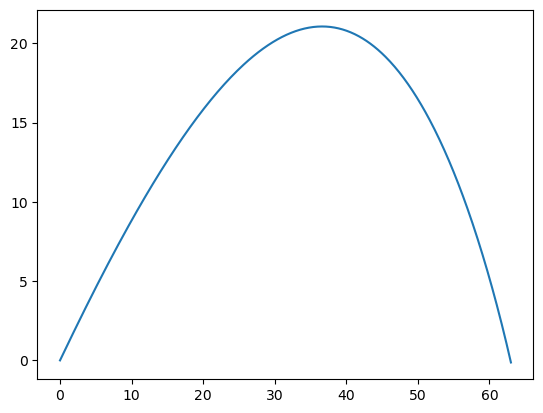

In [38]:
recovered_list = msgpack.load(open( 'trajektorie.dat', "rb" ), ext_hook=dnc)
which = 43.5
for traj in recovered_list:
    if traj.id == which:
        id_rec =traj.id
        x_rec =traj.X
        y_rec =traj.Y

print(id_rec)
plt.plot(x_rec,y_rec)

OPTYMALIZACJA FIBONACCI

In [109]:
def Lstar(j,Li,iters):
    F = np.zeros(iters+1)
    F[0] = 1
    F[1] = 1
    i = 2
    while i<=iters:
        F[i] = F[i-1] + F[i-2]
        i = i + 1

    F = F[1:len(F)]
    L = F[iters-j-1]/F[iters-j+1] * Li
    return L

47.06058408379348
47.058043323298776 191.78496333975608


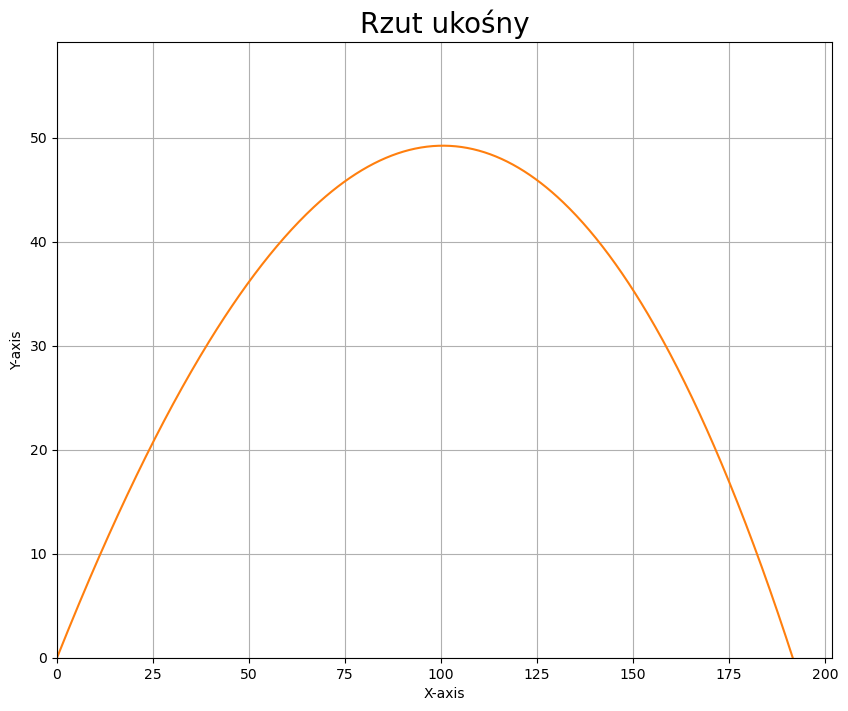

In [159]:
iters = 20
alfa_a = 0
alfa_b = 90
a1 = alfa_a
b1 = alfa_b

ai = a1
bi = b1
L0 = bi - ai
Li = L0
x1 = ai + Lstar(2,Li,iters)
x2 = bi - Lstar(2,Li,iters)
identificator = 1
i = 2
while i<=iters:
    f1 = zasieg(x1,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,identificator)[0]
    f2 = zasieg(x2,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,identificator)[0]
    if f2 > f1:
        ai = ai
        bi = x2
        x2 = x1
        Li = bi - ai
        if i!=iters:
            x1 = ai + Lstar(i,Li,iters)
    else:
        bi = bi
        ai = x1
        x1 = x2
        Li = bi - ai
        if i!=iters:
            x2 = bi - Lstar(i,Li,iters)
    i = i + 1

print(x1)

delta = 0.1
fx = zasieg(x1,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,identificator)[0]
f1 = zasieg(x1 - delta,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,identificator)[0]
f2 = zasieg(x2 + delta,dt,tp,tk,x0,y0,v0,eps,dt2,N,draw,identificator)[0]
if f1 > f2:
    xstar = (x1 + bi) / 2
else:
    xstar = (x1 + ai) / 2

Dstar = -zasieg(xstar,dt,tp,tk,x0,y0,v0,eps,dt2,N,1,identificator)[0]

print(xstar,Dstar)